In [1]:
from pymol import cmd
import py3Dmol

from vina import Vina

from openbabel import pybel

from rdkit import Chem
from rdkit.Chem import AllChem, Draw

from meeko import MoleculePreparation
from meeko import obutils

import MDAnalysis as mda
from MDAnalysis.coordinates import PDB

import prolif as plf
from prolif.plotting.network import LigNetwork


import sys, os
sys.path.insert(1, 'utilities/')
from utils import fix_protein, getbox, generate_ledock_file, pdbqt_to_sdf, dok_to_sdf


import warnings
warnings.filterwarnings("ignore")
%config Completer.use_jedi = False

/opt/anaconda3/envs/Docking/lib/python3.8/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/opt/anaconda3/envs/Docking/lib/python3.8/site-packages/MDAnalysis/coordinates/TRJ.py:1112: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):


In [2]:
os.chdir('test/test/')

In [3]:
cmd.fetch(code='1AZ8',type='pdb1')
cmd.select(name='Prot',selection='polymer.protein')
cmd.select(name='Lig',selection='organic')
cmd.save(filename='1AZ8_clean.pdb',format='pdb',selection='Prot')
cmd.save(filename='1AZ8_lig.mol2',format='mol2',selection='Lig')
cmd.delete('all')

In [5]:
!../../bin/lepro_mac

************************************************************
*      LePro                                               *
*            Add hydrogen atoms to a protein &             *
*            write the input file for LeDock               *
*      Copyright (C) 2013-14 Hongtao Zhao, PhD             *
*      Email: htzhaovv@gmail.com                           *
************************************************************
----------Usage:                                                                       
          lepro [PDB file] [-rot || -metal || -p]                                        
          -rot  [[chain] resid] align principal axes of the binding site with Cartesian
          -metal keep ZN/MN/CA/MG                                                      
          -metal -p redistribute metal charge to protein                               



In [6]:
!../../bin/lepro_mac {'1AZ8_clean.pdb'}

os.rename('pro.pdb','1AZ8_clean_H.pdb') 

[18:47:54] 1AZ8: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
RDKit WARNING: [18:47:54] 1AZ8: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


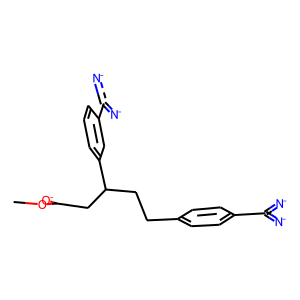

In [7]:
m=Chem.MolFromMol2File('1AZ8_lig.mol2',sanitize=False)
Draw.MolToImage(m)

In [8]:
mol= [m for m in pybel.readfile(filename='1AZ8_lig.mol2',format='mol2')][0]
mol.addh()
out=pybel.Outputfile(filename='1AZ8_lig_H.mol2',format='mol2',overwrite=True)
out.write(mol)
out.close()

*** Open Babel Warning  in ReadMolecule
  Failed to kekulize aromatic bonds in MOL2 file (title is 1AZ8)



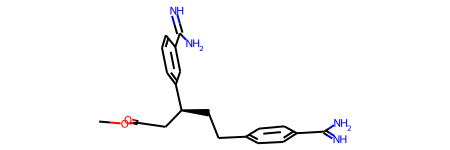

In [9]:
m=Chem.MolFromMol2File('1AZ8_lig_H.mol2')
m

In [10]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('1AZ8_clean_H.pdb','r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})


view.addModel(open('1AZ8_lig_H.mol2','r').read(),format='mol2')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})

view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [12]:
!/Users/panda/ADFRsuite_x86_64Darwin_1.0/bin/prepare_receptor

prepare_receptor4: receptor filename must be specified.
Usage: prepare_receptor4.py -r filename

    Description of command...
         -r   receptor_filename 
        supported file types include pdb,mol2,pdbq,pdbqs,pdbqt, possibly pqr,cif
    Optional parameters:
        [-v]  verbose output (default is minimal output)
        [-o pdbqt_filename]  (default is 'molecule_name.pdbqt')
        [-A]  type(s) of repairs to make: 
             'bonds_hydrogens': build bonds and add hydrogens 
             'bonds': build a single bond from each atom with no bonds to its closest neighbor
             'hydrogens': add hydrogens
             'checkhydrogens': add hydrogens only if there are none already
             'None': do not make any repairs 
             (default is 'None')
        [-C]  preserve all input charges ie do not add new charges 
             (default is addition of gasteiger charges)
        [-p]  preserve input charges on specific atom types, eg -p Zn -p Fe
        [-U]  cle

In [13]:
!/Users/panda/ADFRsuite_x86_64Darwin_1.0/bin/prepare_receptor -v -r {'1AZ8_clean_H.pdb'} -o {'1AZ8_clean_H.pdbqt'}

set verbose to  True
set receptor_filename to  1AZ8_clean_H.pdb
set outputfilename to  1AZ8_clean_H.pdbqt
read  1AZ8_clean_H.pdb
setting up RPO with mode= automatic and outputfilename=  1AZ8_clean_H.pdbqt
charges_to_add= gasteiger
delete_single_nonstd_residues= None
adding gasteiger charges to peptide


In [14]:
!/Users/panda/ADFRsuite_x86_64Darwin_1.0/bin/prepare_ligand -v -l {'1AZ8_lig_H.mol2'} -o {'1AZ8_lig_H.pdbqt'}

set verbose to  True
set ligand_filename to  1AZ8_lig_H.mol2
set outputfilename to  1AZ8_lig_H.pdbqt
read  1AZ8_lig_H.mol2
setting up LPO with mode= automatic and outputfilename=  1AZ8_lig_H.pdbqt
and check_for_fragments= False
and bonds_to_inactivate= 
returning  0
No change in atomic coordinates


In [15]:
cmd.load(filename='1AZ8_clean_H.pdb',format='pdb',object='prot')
cmd.load(filename='1AZ8_lig_H.mol2',format='mol2',object='lig')

center, size= getbox(selection='lig',extending=5.0,software='vina')

cmd.delete('all')

print(center,'\n',size)

{'center_x': 31.859049797058105, 'center_y': 13.347449779510498, 'center_z': 17.06589984893799} 
 {'size_x': 24.56949806213379, 'size_y': 18.123299598693848, 'size_z': 17.374399185180664}


In [16]:
v = Vina(sf_name='vina')

v.set_receptor('1AZ8_clean_H.pdbqt')

v.set_ligand_from_file('1AZ8_lig_H.pdbqt')

v.compute_vina_maps(center=[center['center_x'], center['center_y'], center['center_z']], 
                    box_size=[size['size_x'], size['size_y'], size['size_z']])

'''
# Score the current pose
energy = v.score()
print('Score before minimization: %.3f (kcal/mol)' % energy[0])

# Minimized locally the current pose
energy_minimized = v.optimize()
print('Score after minimization : %.3f (kcal/mol)' % energy_minimized[0])
v.write_pose('1iep_ligand_minimized.pdbqt', overwrite=True)
'''

# Dock the ligand
v.dock(exhaustiveness=10, n_poses=10)
v.write_poses('1AZ8_lig_vina_out.pdbqt', n_poses=20, overwrite=True)

Computing Vina grid ... done.
Performing docking (random seed: -1986092188) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


In [17]:
pdbqt_to_sdf(pdbqt_file='1AZ8_lig_vina_out.pdbqt',output='1AZ8_lig_vina_out.sdf')


In [18]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('1AZ8_clean_H.pdb','r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})


view.addModel(open('1AZ8_lig_H.mol2','r').read(),format='mol2')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'magentaCarbon','radius':0.2}})


results=Chem.SDMolSupplier('1AZ8_lig_vina_out.sdf')

p=Chem.MolToMolBlock(results[0],False)

print('Reference: Magenta | Vina Pose: Cyan')
print ('Pose: {} | Score: {}'.format(results[0].GetProp('Pose'),results[0].GetProp('Score')))

view.addModel(p,'mol')
x = view.getModel()
x.setStyle({},{'stick':{'colorscheme':'cyanCarbon','radius':0.2}})

view.zoomTo()
view.show()

Reference: Magenta | Vina Pose: Cyan
Pose: 1 | Score: -7.718


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [19]:
fix_protein(filename='1AZ8_clean.pdb',addHs_pH=7.4,try_renumberResidues=True,output='1AZ8_clean_H_fix.pdb')

In [20]:
# load protein
prot = mda.Universe("1AZ8_clean_H_fix.pdb")
prot = plf.Molecule.from_mda(prot)
prot.n_residues

# load ligands
lig_suppl = list(plf.sdf_supplier('1AZ8_lig_vina_out.sdf'))
# generate fingerprint
fp = plf.Fingerprint()
fp.run_from_iterable(lig_suppl, prot)
results_df = fp.to_dataframe(return_atoms=True)
results_df

  0%|          | 0/10 [00:00<?, ?it/s]

ligand               UNL1                                          
protein          ASP189.A      CYS191.A      GLY216.A      GLY219.A
interaction       HBDonor   Hydrophobic       HBDonor       HBDonor
Frame                                                              
0            (None, None)  (None, None)  (None, None)        (9, 0)
1            (None, None)  (None, None)  (None, None)  (None, None)
2            (None, None)       (16, 0)  (None, None)        (9, 0)
3            (None, None)       (31, 0)  (None, None)  (None, None)
4            (None, None)  (None, None)  (None, None)  (None, None)
5            (None, None)  (None, None)  (None, None)  (None, None)
6                 (25, 0)  (None, None)  (None, None)       (26, 0)
7            (None, None)  (None, None)  (None, None)       (23, 0)
8            (None, None)  (None, None)       (12, 0)  (None, None)
9            (None, None)        (2, 0)  (None, None)  (None, None)

In [21]:
net = LigNetwork.from_ifp(results_df,lig_suppl[0],kind="frame", frame=0,rotation=270)
net.display()